In [2]:
# Relevant Libraries
import sys

sys.path.append("./../..")

from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE
from sbi.utils.user_input_checks import (
    process_prior,
)
import torch
from IPython.utils import io

2024-08-13 08:22:15.207727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 08:22:16.497061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Ornstein-Uhlenbeck Process

The Ornstein–Uhlenbeck process is a stochastic process that describe the movement of a particle under the influence of friction.
We can describe the process as a stochastic differential equation (SDE) of the form:

$$
dx = -k dt + D dW
$$

We use the following update rule in the simulator:
$$
x_{t+1} = x_t - k x_t dt + \sigma \sqrt{2D} \mathcal{N}(0,\sqrt{dt})
$$

In [3]:
# The Simulator
@jit
def OrnsteinUhlenbeck(param, n_sim, dt = 0.01, TotalT = 1):
    k = param[0]
    D = param[1]
    time_steps_amount = np.int64(TotalT/dt)

    x = np.zeros((1, n_sim))
    x_tilde = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, time_steps_amount))
    
    for t in np.arange(0, time_steps_amount):
        
        x_tilde[:]   = x[:] + -k * x[:] * dt + np.sqrt(2*D) * np.random.normal(0, np.sqrt(dt), size = (1,n_sim))
        x[:]         = x_tilde + (+k * x[:] - k*x_tilde[:])*dt /2
        x_trace[:,t] = x[:,]
    
    return x_trace

Let us define the parameters of our model and simulation. As this is a highly stochastic model, we will run the simulation for a large number of particles.

In [4]:
ModelParameter = [10., 3.] # [k, D]
NumberOfParticles = 1000 # Number of particles to simulate
TotalTime = 20 # Total time of simulation
dt = 1e-2 # Time step
t = np.arange(0, TotalTime, dt) # Time vector
prior_limits = {"k": [10.0,20.0],
                "D": [0.0,2.0]}

Let be noted that `ModelParameter` is a matrix of shape `(2, n_particles)` where the first column is the elastic constant $k$ and the second column is diffusion constant $D$.

Let's simulate a single example particle and visualize its trajectory.

In [6]:
# Run the simulation
x_trace = OrnsteinUhlenbeck(ModelParameter, n_sim = 10, dt = dt, TotalT = TotalTime)

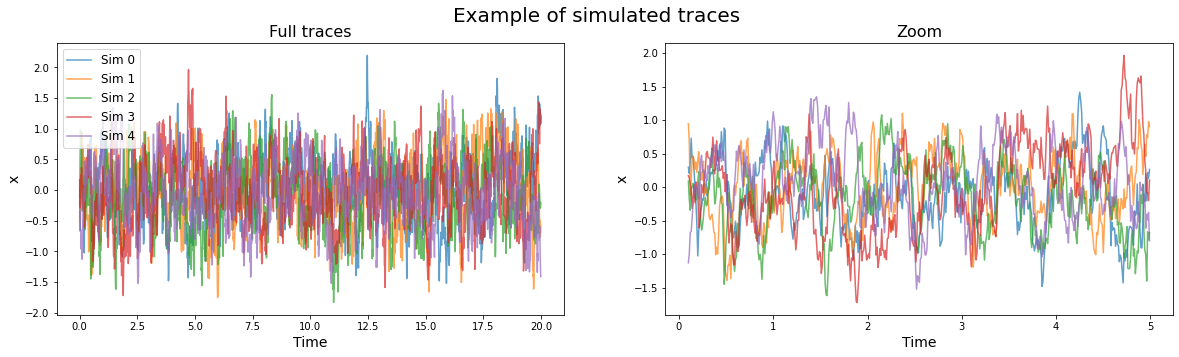

In [7]:
# Example of simulated traces
plt.figure(figsize=(20, 5))
plt.suptitle("Example of simulated traces", fontsize=20)

plt.subplot(121)
for i in range(min([10, 5])):
    plt.plot(t[:], x_trace[i], label=f"Sim {i}", alpha=0.7)
plt.title("Full traces", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("x", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
for i in range(min([10, 5])):
    plt.plot(t[10:500], x_trace[i, 10:500], label=f"Sim {i}", alpha=0.7)
plt.title("Zoom", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("x", fontsize=14);


## Theoretical Observables

We know check the validity of our simulator against some well-known theoretical observables.
First we will check the first moment. This is the mean position of the particle at time $t$, and should be approximatly 0 at all times.

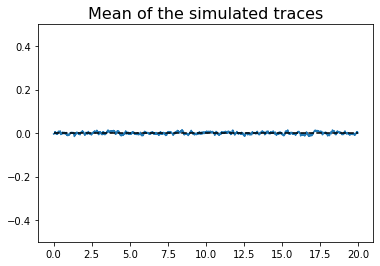

In [8]:
# Generate some traces
x = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = TotalTime)
simulated_mean = np.mean(x, axis = 0)

plt.plot(t, simulated_mean, label = "Mean")
plt.title("Mean of the simulated traces", fontsize=16)
plt.hlines(0, 0, TotalTime, color = "black", linestyle = "--")
plt.ylim([-0.5, 0.5]);

We now check the second moment, that should be given by the following equation:
$$
\langle x^2 \rangle = \frac{D}{k} (1 - e^{-2kt})
$$

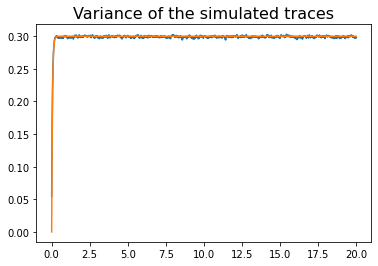

In [9]:
x = OrnsteinUhlenbeck(ModelParameter, n_sim = 100000, dt = dt, TotalT = TotalTime)
simulated_variance = np.var(x, axis = 0)

def OU_variance(t, k, D):
    return D / (k) * (1 - np.exp(-2*k*t))

plt.plot(t, simulated_variance, label = "Variance")
plt.plot(t, OU_variance(t, ModelParameter[0], ModelParameter[1]), label = "Theoretical variance")
plt.title("Variance of the simulated traces", fontsize=16);

Now we check the autocorrelation function, that should be given by the following equation:
$$
\langle x(t) x(t + \tau) \rangle = \frac{D}{k} e^{-2k \tau}
$$

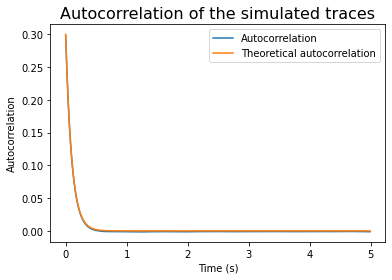

In [10]:
# Generate some traces
x = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 50)

# Calculate the autocorrelation
autocorrelation = np.array([stat_corr_single(x[i], dt) for i in range(x.shape[0])])
autocorrelation = np.mean(autocorrelation, axis = 0)

def OU_autocorrelation(t, k, D):
    return (D/k) * np.exp(-k*t)


t_max = int(5/dt)
fig, ax = plt.subplots()
ax.plot(t[:t_max], autocorrelation[:t_max], label = "Autocorrelation")
ax.plot(t[:t_max], OU_autocorrelation(t, ModelParameter[0], ModelParameter[1])[:t_max], label = "Theoretical autocorrelation")
ax.set_title("Autocorrelation of the simulated traces", fontsize=16)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.legend();

It's very important to note that to calculate the autocorrelation function in an accurate way, it must be computed on a very long trajectory. As the characteristic time of the process is $1/k$, we need to simulate the process for a time much larger than $1/k$. In the following graph we can see when the autocorrelation function converges to the theoretical value. In this notebook we analyze the range $k \in [10, 20]$ so that the characteristic time is in the range $[0.05, 0.1]s$.

Error 5s: 0.0060
Error 10s: 0.0030
Error 20s: 0.0015
Error 30s: 0.0010
Error 40s: 0.0008
Error 50s: 0.0006


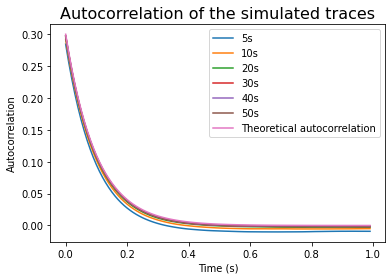

In [11]:
# Generate some traces
x1  = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 5)
x10 = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 10)
x20 = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 20)
x30 = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 30)
x40 = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 40)
x50 = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 50)

# Calculate the autocorrelation
autocorrelation1 = np.mean(np.array([stat_corr_single(x1[i], dt) for i in range(x1.shape[0])]),axis=0)
autocorrelation10 = np.mean(np.array([stat_corr_single(x10[i], dt) for i in range(x1.shape[0])]),axis=0)
autocorrelation20 = np.mean(np.array([stat_corr_single(x20[i], dt) for i in range(x1.shape[0])]),axis=0)
autocorrelation30 = np.mean(np.array([stat_corr_single(x30[i], dt) for i in range(x1.shape[0])]),axis=0)
autocorrelation40 = np.mean(np.array([stat_corr_single(x40[i], dt) for i in range(x1.shape[0])]),axis=0)
autocorrelation50 = np.mean(np.array([stat_corr_single(x50[i], dt) for i in range(x1.shape[0])]),axis=0)


def OU_autocorrelation(t, k, D):
    return (D/k) * np.exp(-k*t)


t_max = int(1/dt)
fig, ax = plt.subplots()
ax.plot(t[:t_max], autocorrelation1[:t_max], label = "5s")
ax.plot(t[:t_max], autocorrelation10[:t_max], label = "10s")
ax.plot(t[:t_max], autocorrelation20[:t_max], label = "20s")
ax.plot(t[:t_max], autocorrelation30[:t_max], label = "30s")
ax.plot(t[:t_max], autocorrelation40[:t_max], label = "40s")
ax.plot(t[:t_max], autocorrelation50[:t_max], label = "50s")


ax.plot(t[:t_max], OU_autocorrelation(t, ModelParameter[0], ModelParameter[1])[:t_max], label = "Theoretical autocorrelation")
ax.set_title("Autocorrelation of the simulated traces", fontsize=16)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.legend();

# Calculate average error from the theoretical autocorrelation
error1 = np.mean(np.abs(autocorrelation1 - OU_autocorrelation(np.arange(0, 5, dt), ModelParameter[0], ModelParameter[1])))
error10 = np.mean(np.abs(autocorrelation10 - OU_autocorrelation(np.arange(0, 10, dt), ModelParameter[0], ModelParameter[1])))
error20 = np.mean(np.abs(autocorrelation20 - OU_autocorrelation(np.arange(0, 20, dt), ModelParameter[0], ModelParameter[1])))
error30 = np.mean(np.abs(autocorrelation30 - OU_autocorrelation(np.arange(0, 30, dt), ModelParameter[0], ModelParameter[1])))
error40 = np.mean(np.abs(autocorrelation40 - OU_autocorrelation(np.arange(0, 40, dt), ModelParameter[0], ModelParameter[1])))
error50 = np.mean(np.abs(autocorrelation50 - OU_autocorrelation(np.arange(0, 50, dt), ModelParameter[0], ModelParameter[1])))

print(f"Error 5s: {error1:.4f}")
print(f"Error 10s: {error10:.4f}")
print(f"Error 20s: {error20:.4f}")
print(f"Error 30s: {error30:.4f}")
print(f"Error 40s: {error40:.4f}")
print(f"Error 50s: {error50:.4f}")

## Entropy Production

???

## Implementing SBI

We now try to apply the SBI algorithm to infer the parameters of the model. We will use the simulator to generate the data and the SBI algorithm to infer the parameters. 
We will use a simple flat prior for the parameters and explore different summary statistics to see how they affect the inference.

Lastly we will try to use Multi-Round inference to improve the results of the SBI algorithm.

In [12]:
def GenerateDataForSBI(n_sim, prior_limits, dt = 0.01, TotalT = 1, constant_k = None, constant_D = None, method = "RAW"):
    t = np.arange(0, TotalT, dt)
    
    # Generate the parameters
    if constant_k is not None:
        k_param = np.repeat(constant_k, n_sim)
    else:
        k_param = np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], n_sim)
    
    if constant_D is not None:
        D_param = np.repeat(constant_D, n_sim)
    else:
        D_param = np.random.uniform(prior_limits["D"][0], prior_limits["D"][1], n_sim)
    
    params = np.array([k_param, D_param])    
    
    # Simulate the data
    trace = OrnsteinUhlenbeck(params, n_sim, dt, TotalT)
    
    
    # Save the trace and the parameters in the correct format
    trace = torch.tensor(np.array(trace)).float()
    params = torch.tensor(np.array(params)).float()

    # Save the prior for MultiRound
    prior = utils.BoxUniform(low=torch.tensor([prior_limits["k"][0], prior_limits["D"][0]]), high=torch.tensor([prior_limits["k"][1], prior_limits["D"][1]]))
    prior, _, _ = process_prior(prior)
    
    # Apply Summary Statistics
    SummaryStat = ApplySummaryStatistics(trace.numpy(), method = method, t = t, dt = dt)
    SummaryStat = torch.tensor(SummaryStat).float()
    
    return SummaryStat, params.T, prior

def ApplySummaryStatistics(trace, method, dt, t = None):
    if method == "RAW":
        return trace
    elif method == "correlation":
        return np.array([stat_corr_single(trace[i], dt) for i in range(trace.shape[0])])
    elif method == "correlation_fit":
        if t is None:
            raise ValueError("t must be provided")
        def OU_autocorrelation(t, A, B):
            return A * np.exp(-B*t)
        
        c = ApplySummaryStatistics(trace, method = "correlation", dt = dt)
        params = np.zeros((c.shape[0], 2))
        idx = np.logspace(0, np.log10(c.shape[1]/50), 20).astype(int)
        
        for i in range(c.shape[0]):
            popt, pcov = curve_fit(OU_autocorrelation, t[idx], c[i,idx], p0 = [1, 1])
            params[i] = popt
        
        return params
        
    else:
        raise ValueError("Method not recognized")

def CompleteSBIPipeline(n_sim, prior_limits, dt, TotalTime, method = "RAW", rounds = 1, constant_k = None, constant_D = None, plot = True, TotalTestTime = None):
    if TotalTestTime is None:
        TotalTestTime = TotalTime
    t = np.arange(0, TotalTime, dt)
    x, theta, prior = GenerateDataForSBI(n_sim, prior_limits, dt, TotalTime, method = method, constant_k = constant_k, constant_D = constant_D)
    x_test, theta_test, _ = GenerateDataForSBI(1, prior_limits, dt, TotalTestTime, method = method, constant_k = constant_k, constant_D = constant_D)
    inference = SNPE(prior=prior)
    proposal = prior
    
    for _ in np.arange(rounds):
        density_estimator = inference.append_simulations(theta, x, proposal = proposal).train(show_train_summary=False)
        posterior = inference.build_posterior(density_estimator)
        print("\n")
        proposal = posterior.set_default_x(x_test)
    
    
    samples = posterior.sample((100000,), x=x_test.reshape(1, x_test.shape[1]), show_progress_bars=False)
    centroids, centroid_spread = GetCentroid(samples)
    if plot:
        PlotSBIResults(samples, theta_test, prior_limits, centroids, centroid_spread)
    prior_ranges = np.array([prior_limits["k"][1] - prior_limits["k"][0], prior_limits["D"][1] - prior_limits["D"][0]])
    compat = np.abs((centroids - theta_test) / prior_ranges) # Cambiare con i limiti della prior

    return centroids, centroid_spread, theta_test, compat

def LimitsForPlot(prior_limits):
    limits = []
    for key in prior_limits.keys():
        limits.append(prior_limits[key])
    return limits

def GetCentroid(samples):
    centroids = samples.mean(axis=0)
    centroid_spread = samples.std(axis=0)
    
    return centroids, centroid_spread

def PlotSBIResults(samples, theta_test, prior_limits,centroids, centroid_spread, labels=[r"$k$", r"$D$"], **kwargs):

    fig, axes = analysis.pairplot(samples, points=theta_test, limits=LimitsForPlot(prior_limits), figsize=(5, 3), labels=[r"$k$", r"$D$"], **kwargs)
    
    textstr1 = '\n'.join((
        r'$k_{SBI}=%.2f \pm %.2f$' % (centroids[0], centroid_spread[0]),
        r'$D_{SBI}=%.2f\pm %.2f$' % (centroids[1], centroid_spread[1])))
    
    textstr2 = '\n'.join((
        r'$k_{True}=%.2f$' % theta_test[0][0],
        r'$D_{True}=%.2f$' % theta_test[0][1]))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axes[-1,1].text(-1.2, 0, textstr1, transform=axes[-1,1].transAxes, fontsize=12,
            verticalalignment='top', bbox=props);
    
    axes[-1,0].text(0, 0.6, textstr2, transform=axes[-1,0].transAxes, fontsize=12,
            verticalalignment='top', bbox=props);
    
    return centroids, centroid_spread

def EvaluateSBI(n_runs = 10, SBI_params = {}, plot = True):
    distances = np.zeros((n_runs, 2))
    centroidss = np.zeros((n_runs, 2))
    centroid_spreads = np.zeros((n_runs, 2))
    theta_tests = np.zeros((n_runs, 2))
    
    for i in np.arange(n_runs):
        print(f"\rRun {i+1}/{n_runs}                         ", end = "")
        with io.capture_output() as captured:
            centroids, centroid_spread, theta_test, compat = CompleteSBIPipeline(**SBI_params)
        print("\r                                                                   \r",end="")
        centroidss[i] = centroids
        centroid_spreads[i] = centroid_spread
        theta_tests[i] = theta_test
        distances[i] = centroids - theta_test
    
    if plot:
        SBIEvaluationPlot(centroidss, theta_tests, centroid_spreads)

    return distances, centroidss, centroid_spreads, theta_tests

def SBIEvaluationPlot(centroidss, theta_tests, centroid_spreads):
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].errorbar(theta_tests[:,0], centroidss[:,0], yerr=centroid_spreads[:,0], xerr=0, fmt='o', color='blue', alpha = 0.5)
    axes[0].plot([10,20], [10,20], color = "black", linestyle = "--", alpha = 0.2)
    axes[0].set_title(r"Parameter $k$")
    axes[0].set_xlabel("Real Parameter")
    axes[0].set_ylabel("Estimated Parameter")
    
    axes[1].errorbar(theta_tests[:,1], centroidss[:,1], yerr=centroid_spreads[:,1], xerr=0, fmt='o', color='blue', alpha = 0.5)
    axes[1].plot([0,2], [0,2], color = "black", linestyle = "--", alpha = 0.2)
    axes[1].set_title(r"Parameter $D$")
    axes[1].set_xlabel("Real Parameter")
    axes[1].set_ylabel("Estimated Parameter")

    fig.suptitle("Estimate vs Real");
    print(f"Average k error: {np.mean(np.abs(centroidss[:,0] - theta_tests[:,0])):.2f}") # If guessing at random, error is 2.5
    print(f"Average D error: {np.mean(np.abs(centroidss[:,1] - theta_tests[:,1])):.2f}") # If guessing at random, error is 0.5
    
def SBI_vs_X(SBI_params,X, n_runs = 10, plot = True):
    """
    X is the name of the parameter to be changed
    """
    distances = np.zeros((SBI_params[X].shape[0], 2))
    stds = np.zeros((SBI_params[X].shape[0], 2))
    
    X_DATA = SBI_params[X]
    
    for i in np.arange(X_DATA.shape[0]):
        print("\rIteration: ", i+1, end = "")
        with io.capture_output() as captured:
            SBI_params[X] = X_DATA[i]
            D, C, CS, TT = EvaluateSBI(n_runs = n_runs, SBI_params = SBI_params, plot=False)
        distances[i] = np.mean(np.abs(D), axis = 0)
        stds[i] = np.std(np.abs(D), axis = 0)
    
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize = (20,5))
        ax[0].errorbar(X_DATA, distances[:,0], yerr = stds[:,0], label = "k", capsize = 5)
        ax[1].errorbar(X_DATA, distances[:,1], yerr = stds[:,1], label = "D", capsize = 5)
        ax[0].set_title("Error in k")
        ax[1].set_title("Error in D")
        ax[0].set_xlabel(X)
        ax[1].set_xlabel(X)
        ax[0].set_ylabel("Error")
        ax[1].set_ylabel("Error")
    
    return distances, stds

### SBI: Raw Traces

 Neural network successfully converged after 23 epochs.



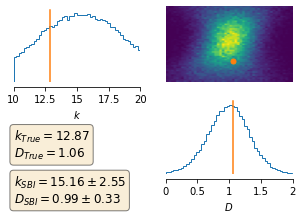

In [13]:
centroids, centroid_spread, theta_test, compat = CompleteSBIPipeline(1000, prior_limits, dt, TotalTime=TotalTime, method = "RAW", rounds = 1, plot = True)

We will evaluate the SBI algorithm performance by applying it to numerous test cases and recording how much the inferred parameters deviate from the true parameters.

Average k error: 2.70                                              
Average D error: 0.49


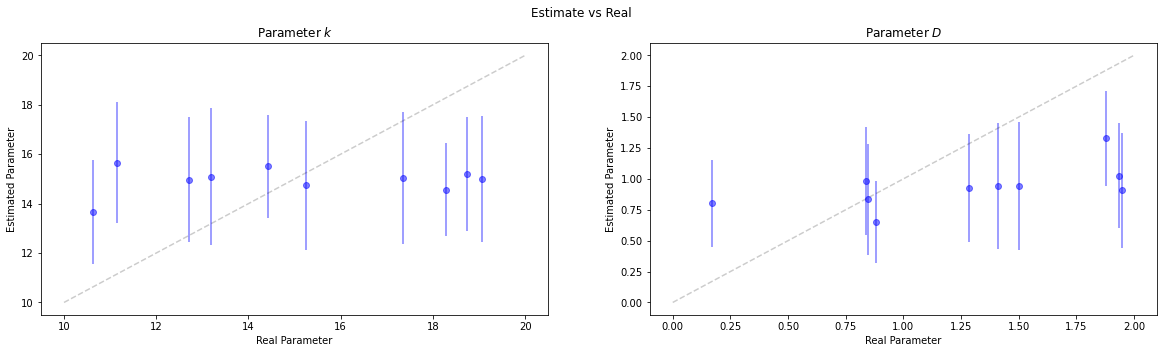

In [14]:
SBI_params = {"n_sim": 1000, "prior_limits": prior_limits, "dt": dt, "TotalTime": TotalTime, "method": "RAW", "rounds": 1, "plot": False}
distances, centroidss, centroid_spreads, theta_tests = EvaluateSBI(n_runs = 10, SBI_params = SBI_params)

We can see that giving the raw trajectories is not useful, and SBI gives almost always the same answer (the mean of our prior).

### SBI: Autocorrelation Traces

Average k error: 2.39                                              
Average D error: 0.31


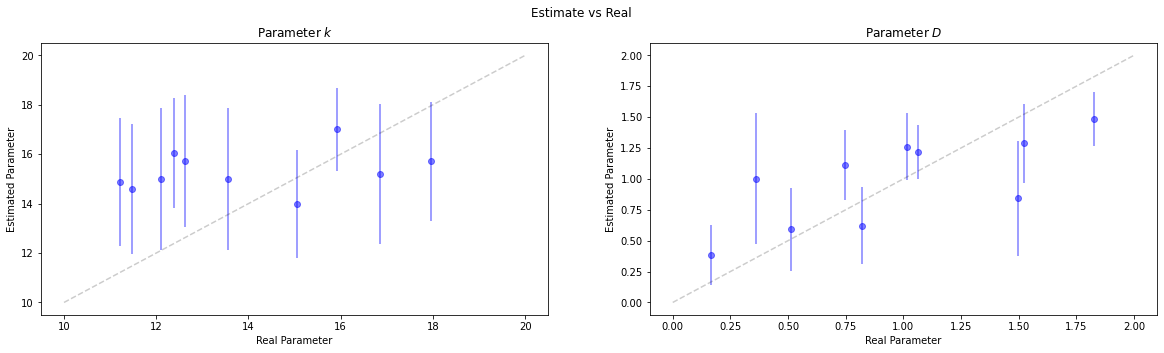

In [16]:
SBI_params = {"n_sim": 500, "prior_limits": prior_limits, "dt": dt, "TotalTime": TotalTime, "method": "correlation", "rounds": 1, "plot": False}
distances, centroidss, centroid_spreads, theta_tests = EvaluateSBI(n_runs = 10, SBI_params = SBI_params)

As we know the correlation traces ought to be the same given the same initial parameters. But as we can see, again using the full trace is not useful in this type of situation.

### SBI: AutoCorrelation Fit

 Neural network successfully converged after 113 epochs.



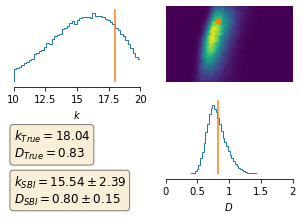

In [17]:
centroids, centroid_spread, theta_test, compat = CompleteSBIPipeline(500, prior_limits, dt, TotalTime=2, method = "correlation_fit", rounds = 1, plot = True, TotalTestTime = 10)

Average k error: 0.87                                              
Average D error: 0.06


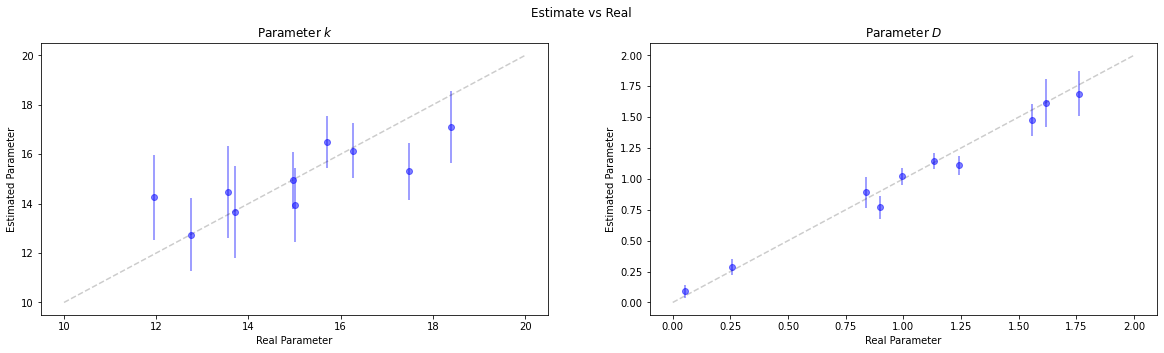

In [18]:
SBI_params = {"n_sim": 100, "prior_limits": prior_limits, "dt": dt, "TotalTime": 50, "method": "correlation_fit", "rounds": 1, "plot": False}
distances, centroidss, centroid_spreads, theta_tests = EvaluateSBI(n_runs = 10, SBI_params = SBI_params)

We can see that by condensing the information of the correlation in just two parameters we managed to give a very good input to SBI, that gives consistently good results. We notice that the $D$ parameter appears to be much more accurate than $k$

Next, we try to understand how different parameters influences the final output of SBI.
We try to measure the accuracy of the SBI prediction by analysing the mean absolute distance between estimated and real parameter over multiple runs.

In [19]:
n_sim = np.array([100,200,300,400,500,1000,2000,5000,10000])
SBI_params = {"n_sim": n_sim, "prior_limits": prior_limits, "dt": dt, "TotalTime": 50, "method": "correlation_fit", "rounds": 1, "plot": False}
distances, stds = SBI_vs_X(SBI_params, "n_sim")

Iteration:  8

In [ ]:
TotalTime = np.array([10,20,30,40,50,60,70,80,90,100])
SBI_params = {"n_sim": 200, "prior_limits": prior_limits, "dt": dt, "TotalTime": TotalTime, "method": "correlation_fit", "rounds": 1, "plot": False, "TotalTestTime":10}
distances, stds = SBI_vs_X(SBI_params, "TotalTime")

In [ ]:
TotalTime = np.array([10,20,30,40,50,60,70,80,90,100])
SBI_params = {"n_sim": 200, "prior_limits": prior_limits, "dt": dt, "TotalTime": TotalTime, "method": "correlation_fit", "rounds": 1, "plot": False}
distances, stds = SBI_vs_X(SBI_params, "TotalTime")

### SBI: Multi-Round Inference

We now try to implement the so called "Multi-Round Inference" in our workflow. This is not very difficult, and as we can see, it improves the precision of our posteriors, but not so much their accuracy. This means that our confidence interval is narrower, but it's not nearer our true value compared to the single round inference.

In [ ]:
SBI_params = {"n_sim": 100, "prior_limits": prior_limits, "dt": dt, "TotalTime": 50, "method": "correlation_fit", "rounds": 2, "plot": False}
distances, centroidss, centroid_spreads, theta_tests = EvaluateSBI(n_runs = 10, SBI_params = SBI_params)

In [ ]:
rounds = np.array([1,2,3,4,5,6,7,8,9,10])
SBI_params = {"n_sim": 200, "prior_limits": prior_limits, "dt": dt, "TotalTime": 80, "method": "correlation_fit", "rounds": rounds, "plot": False}
distances, stds = SBI_vs_X(SBI_params, "rounds")